In [0]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.utils import plot_model
from keras.engine import Layer
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from google.colab import drive

Using TensorFlow backend.


In [0]:
!wget -cq http://press.liacs.nl/mirflickr/mirflickr25k.v2/mirflickr25k.zip

In [0]:
!unzip -qq mirflickr25k.zip

In [0]:
onlyfiles = next(os.walk('/content/mirflickr/'))[2]
print(len(onlyfiles))

list = os.listdir('/content/mirflickr/')
number_files = len(list)
print(number_files)

In [0]:
import shutil
shutil.rmtree('/content/mirflickr/meta')
shutil.rmtree('/content/mirflickr/doc')

In [0]:
onlyfiles = next(os.walk('/content/mirflickr/'))[2]
print(len(onlyfiles))

list = os.listdir('/content/mirflickr/')
number_files = len(list)
print(number_files)

In [0]:
path= "/content/mirflickr/"
i=0
for file in os.listdir(path):
    i+=1
    if(i>5000):
        os.remove(path+file)

In [0]:

from PIL import Image
resize_method = Image.BICUBIC
    #Image.NEAREST)  # use nearest neighbour
    #Image.BILINEAR) # linear interpolation in a 2x2 environment
    #Image.BICUBIC) # cubic spline interpolation in a 4x4 environment
    #Image.ANTIALIAS) # best down-sizing filter


max_height= 128
max_width= 128
extensions= ['JPG']

path= '/content/mirflickr/'

def adjusted_size(width,height):
    return max_width, max_height

	
if __name__ == "__main__":
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path,f)):
            f_text, f_ext= os.path.splitext(f)
            f_ext= f_ext[1:].upper()
            if f_ext in extensions:
                #print(f)
                image = Image.open(os.path.join(path,f))
                width, height= image.size
                image = image.resize(adjusted_size(width, height))
                image.save(os.path.join(path,f))

In [0]:
!unzip -qq output.zip

In [0]:
import shutil
#shutil.rmtree('/content/pred/')
#shutil.rmtree('/content/output/')
os.mkdir('pred/')

In [0]:
X = []
for filename in os.listdir('/content/mirflickr/'):
    X.append(img_to_array(load_img('/content/mirflickr/'+filename)))
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X
print(X.size, Xtrain.size)


245760000 245760000


In [0]:
vgg = VGG16(weights='imagenet', include_top=True)
vgg.graph = tf.get_default_graph()

embed_input = Input(shape=(1000,), name='vggin')

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 6s 0us/step


In [0]:
encoder_input = Input(shape=(128, 128, 1,), name='main_in')
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2, name='e1')(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='e2')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2, name='e3')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', name='e4')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', name='e5')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2, name='e6')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same', name='e7')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same', name='e8')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same', name='e9')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', name='e10')(encoder_output)

#Fusion
fusion_output = RepeatVector(16 * 16)(embed_input) 
fusion_output = Reshape(([16, 16, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same', name='fusionOut')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='de1')(fusion_output)
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='de2')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same', name='de3')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same', name='de4')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same', name='de5')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same', name='de6')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
print(model.summary())
plot_model(model, to_file='model.jpg')


Instructions for updating:
Use tf.cast instead.
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1/1 [==============================] - 10s 10s/step - loss: 0.0230 - acc: 0.5438
Epoch 2/50
1/1 [==============================] - 0s 75ms/step - loss: 0.8989 - acc: 0.3814
Epoch 3/50
1/1 [==============================] - 0s 134ms/step - loss: 0.0184 - acc: 0.6131
Epoch 4/50
1/1 [==============================] - 0s 68ms/step - loss: 0.0131 - acc: 0.6465
Epoch 5/50
1/1 [==============================] - 1s 594ms/step - loss: 0.0134 - acc: 0.4934
Epoch 6/50
1/1 [==============================] - 1s 644ms/step - loss: 0.0144 - acc: 0.6136
Epoch 7/50
1/1 [==============================] - 1s 633ms/step - loss: 0.0152 - acc: 0.6994
Epoch 8/50
1/1 [==============================] - 1s 634ms/step - loss: 0.1421 - acc: 0.5476
Epoch 9/50
1/1 [==============================] - 1s 632ms/step - loss: 0.0145 - acc: 0.7206
Epoch 10/50
1/1 [==============================] - 1s 626ms/step - loss: 0.0111 - acc: 0.6457
Epoch 11/50
1/1 [==============================] - 1s 642ms/step - loss: 0.0152 - a

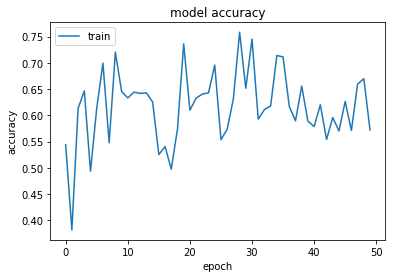

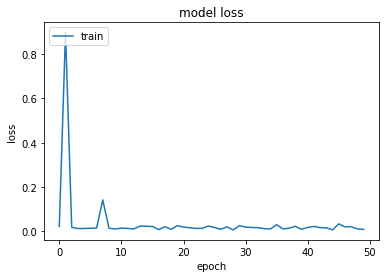

In [0]:

def create_vgg_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (224, 224, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with vgg.graph.as_default():
        embed = vgg.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 16

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_vgg_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_vgg_embedding(grayscaled_rgb)], Y_batch)


#Train model      
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit_generator(image_a_b_gen(batch_size), epochs=50, steps_per_epoch=1)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
color_me = []
for filename in os.listdir('/content/output/'):
    color_me.append(img_to_array(load_img('/content/output/'+filename)))
color_me = np.array(color_me, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*color_me))
color_me_embed = create_vgg_embedding(gray_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))


# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((128, 128, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("/content/pred/img_"+str(i)+".png", lab2rgb(cur))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
!zip -r /content/pred.zip /content/pred/

In [0]:
!/opt/bin/nvidia-smi